# FairFace - Pipeline

### Required Libraries

In [1]:
# pip install dlib

In [2]:
import numpy as np
import cv2
import urllib.request
import os
import csv
import tensorflow
import urllib.request

from clip_retrieval.clip_client import ClipClient, Modality
from matplotlib import pyplot as plt
from deepface import DeepFace
from pathlib import Path
from tqdm import tqdm

from matplotlib import pyplot as plt
import plotly.express as px
import cv2
import numpy as np
from ultralytics import YOLO
import tensorflow as tf
import torch
import math
import pandas

import torchvision
from torchvision import datasets, models, transforms
import torch
import torch.nn as nn
import dlib
import pandas as pd
import random
import statistics

In [3]:
def CamelCase(text):
    """ 
    Description:
    This function is used to convert text into camel case mainly used for determining file names.

    Parameters:
    text (str) - Text to be converted to camel case.

    Returns:
    camel_case_text (str) - The text converted to camel case.
    """
    
    # Splitting the text into words by space
    words = text.split()

    # Capitalising the first letter of each word
    camel_case_words = (word.capitalize() for word in words)

    # Joining the words together to form the CamelCase string
    camel_case_text = ''.join(camel_case_words)

    return camel_case_text

In [4]:
def LoadImagesFromFolder(folder_path):
    """ 
    Description:
    This function is used to load images from the specified folder, mainly to avoid repeatedly going through the process of retrieving the same images. 
    However it can be used to load other images (GenerativeImages).

    Parameters:
    folder_path (str) - Path to the folder in which the images are stored.

    Returns:
    image_list (list) - List containing the loaded images.
    """

    # Initialize an empty list to store the loaded images
    image_list = []

    # Filter out non-image files (e.g., folders, etc.)
    list_of_files = os.listdir(folder_path)

    image_files = [file for file in list_of_files if file.lower().endswith(('.jpg', '.jpeg', '.png', '.gif', '.bmp'))]

    list_of_files = sorted(image_files, key=lambda x: int(x.split('.')[0]))
    print(list_of_files)
    # Loop through the files in the folder
    for file_no in range(len(list_of_files)):
        try:
            filename = str(list_of_files[file_no])

            if filename in list_of_files:
                # Construct the full path to the image file
                image_path = os.path.join(folder_path, filename)

                # Load the image using cv2 in BGR format
                image_bgr = cv2.imread(image_path)

                if image_bgr is not None:
                    # Convert BGR to RGB format
                    image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

                    # Append the RGB image to the list
                    image_list.append(image_rgb)
        except:
            pass
    
    return image_list

In [80]:
def LoadMetricCSVFromFolder(csv_file_path):
    """ 
    Description:
    This function is used to load the image metrics (if saved) from the DeepFaceProcess function, so as to avoid running it multiple times for the same images.

    Parameters:
    csv_file_path (str) - Path to the file containing the metrics.

    Returns:
    data_dict (dict) - Dictionary containing the image and its metrics.
    """

    data_dict = {}

    with open(csv_file_path+"\\output_data.csv", mode='r', newline='') as file:
        reader = csv.DictReader(file)
        header = reader.fieldnames

        image_data = []
        for index, row in enumerate(reader):
            image_no = int(row['Image_No'])
            
            image = cv2.cvtColor(cv2.imread(csv_file_path+"\\"+str(image_no)+".jpg"), cv2.COLOR_BGR2RGB)

            tmp = {key: row[key] for key in header if row[key] != ""}
            
            # Removing the 'Image_No' key as we dont want it saved in the dictionary
            tmp.pop('Image_No', None)
            
            if index % 2 == 0:
                image_data.append(image)
                image_data.append(tmp)
            else:
                # The inner dictionary is saved as a string, so we need to convert it back to a dictionary using eval
                for key in tmp:
                    tmp[key] = eval(tmp[key])
                image_data.append(tmp)
                data_dict[image_no] = image_data
                image_data = []

    return data_dict

In [6]:
def SaveMetricsCSV(sub_folder_path, metric_dict):
    """ 
    Description:
    This function serves to save the dominant values per image resultant from the DeepFaceProcess function to a CSV file. (Used only in DeepFaceProcess function)
    
    Parameters:
    sub_folder_path (str) - Path to the folder in which the images are stored.
    metric_dict (dict) - Dictionary containing the dominant values per image resultant from the DeepFaceProcess fucntion.

    Returns:
    None.
    """
    # Specifying the CSV file path
    csv_file_path = Path(os.path.join(sub_folder_path, 'output_data.csv'))

    # Open the CSV file in write mode
    with open(csv_file_path, 'w', newline='') as csv_file:
        fieldNames = ["Image_No"]

        # Getting the additional fields from the dictionary and adding them to the fieldnames list
        additionalFields = list(metric_dict[0][1].keys())
        fieldNames.extend(additionalFields)
        writer = csv.DictWriter(csv_file, fieldnames=fieldNames)

        # Writing the header row
        writer.writeheader()

        # Write each row for the given structure
        for image_name, (_, dict1, dict2) in metric_dict.items():
            # This list contains the image labels
            label_row = {'Image_No': image_name}
            # This list containst the confidence scores associated with the labels
            confidence_score_row = {'Image_No': image_name}

            # Writing the image properties for each row
            for key in additionalFields:
                # Adding the value where it is present otherwise adding an empty string
                if key in dict1:
                    label_row.update({key:dict1[key]})
                else:
                    label_row.update({key:""})

                if key in dict2:
                    confidence_score_row.update({key:dict2[key]})
                else:
                    confidence_score_row.update({key:""})

            writer.writerow(label_row)
            writer.writerow(confidence_score_row)

In [7]:
def FindObjWithLargestArea(objs):
    """ 
    Description:
    This function serves to detect the object (face) with the largest area in the image. (Used only in DeepFaceProcess function)
    
    Parameters:
    objs (dict) - Dictionary containing the information from the DeepFace.analyze function relevant to the image.

    Returns:
    objectIndex (int) - Index of the object taking up the largest area.
    """
    largestArea = 0
    objectIndex = 0

    for index, obj in enumerate(objs):
        if obj['region']['w'] * obj['region']['h'] > largestArea:
            largestArea = obj['region']['w'] * obj['region']['h']
            objectIndex = index
    return objectIndex

In [8]:
def YOLODetectPerson(model, images, confidence_threshold=0.5):
    """ 
    Description:
    This function serves to detect an entire person in an image.
    
    Parameters:
    model - YOLO model used to detect the person in the image.
    images (list) - List containing the images to be processed.
    confidence_threshold (float) - Confidence threshold to filter out predictions below the threshold.

    Returns:
    cropped_images (list) - List containing the cropped images.
    dist_between_centers (list) - List containing the distance between the centers of the image and the center of the bounding box in each image.
    space_takenup (list) - List containing the percentage of the image taken up by the bounding box in each image.
    """
    
    cropped_images = []
    dist_between_centers = []
    space_takenup = []

    for input_image in images:
        # Making predictions
        predictions = model.predict(input_image, classes=0)

        # Extracting the bounding box coordinates, prediction confidance, prediction class
        boxes = predictions[0].boxes.xyxy  
        scores = predictions[0].boxes.conf
        classes = predictions[0].boxes.cls

        # Filtering out predictions below the confidence threshold
        filtered_indices = torch.where(scores > confidence_threshold)[0]
        filtered_boxes = boxes[filtered_indices]
        filtered_classes = classes[filtered_indices]

        if len(filtered_indices) > 1:
            plt.imshow(input_image)
            plt.show()

        # Finding the area of the image
        area_of_image = input_image.shape[0] * input_image.shape[1]
        image_center_x = input_image.shape[1] // 2
        image_center_y = input_image.shape[0] // 2


        for box, class_id in zip(filtered_boxes, filtered_classes):
            box = box.cpu().numpy().astype(int)
            class_id = int(class_id.cpu().numpy())

            # Crop the image based on the bounding box
            cropped_image = input_image[box[1]:box[3], box[0]:box[2]]
            cropped_images.append(cropped_image)

            area_of_cropped_image = cropped_image.shape[0] * cropped_image.shape[1]
            space_takenup.append(area_of_cropped_image/area_of_image * 100)

            # Add a dot at the center
            center_x = (box[0] + box[2]) // 2
            center_y = (box[1] + box[3]) // 2

            distance_between_centers = math.dist([center_x, center_y], [image_center_x, image_center_y])
            dist_between_centers.append(distance_between_centers)

    return cropped_images, dist_between_centers, space_takenup

### FairFace Model

link: https://github.com/dchen236/FairFace

In [9]:
# This function expectes the images to contain the face only and not the entire image
def FairFaceProcess(listOfImages, fairFaceModel):
    """ 
    Description:
    This function serves to determine the properties of the primary detected face in an image. 
    For each image passed it will only consider the most prominent face, this is done as each 
    image is initially being processed by YOLOv8 to detect/crop individual people and then said images are fed to this function.
    
    Parameters:
    listOfImages (list) - List containing the images to be processed. 
    fairFaceModel - FairFace model used to determine the properties of the face in the image.

    Returns:
    FairFaceDict (dict) - Dictionary containing the information relevant to each image.
    """
    tensorflow.keras.utils.disable_interactive_logging()
    FairFaceDict = {}

    # Create a tqdm progress bar
    progress_bar = tqdm(total=len(listOfImages), desc="Processing", unit="images")

    # Transformation process used to convert images to the expected input format of the fairface model.
    trans = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    for image_index, image in enumerate(listOfImages):
        # These mappings hold the index associated with each label, e.g., man confidence value is stored at index 1 of the gender array.
        # The same applies to the other mappings. These values are then replaced with the confidence associated with each label.
        # The model distinguishes betwen east and southest asian, but these were combined together for the sake of consistency.
        gender_mapping = {"man":0,"woman":1}
        race_mapping = {"white":0,"black":1,"latino hispanic":2,"asian":3,"indian":4,"middle eastern":5}
        age_mapping = {"0-2":0,"3-9":1,"10-19":2,"20-29":3,"30-39":4,"40-49":5,"50-59":6,"60-69":7,"70+":8}

        # Using the mtcnn detector to detect faces in the image
        objs = DeepFace.analyze(image, enforce_detection=False,  detector_backend="mtcnn", silent=True)
            
        # Using the index of the primary face (takes up most area) in the image
        index =  FindObjWithLargestArea(objs)

        # Cropping the image to only include the face
        img_area = objs[index]['region']
        x = img_area['x']
        y = img_area['y']
        width = img_area['x'] + img_area['w']
        height = img_area['y'] + img_area['h']
        faceImg = image[y:height, x:width]

        transformed_image = trans(faceImg)
        transformed_image = transformed_image.view(1, 3, 224, 224) 
        transformed_image = transformed_image.to("cpu")

        outputs = fairFaceModel(transformed_image)
        outputs = outputs.cpu().detach().numpy()
        outputs = np.squeeze(outputs)

        # Retrieving the confidence values for each label
        gender_outputs = outputs[7:9]
        age_outputs = outputs[9:18]

        # This array has probabilities for east asian and southeast asian, so we need to combine them
        race_outputs = outputs[:7]
        # Their values are stored in index 3 and 4, so we will take the average of these two values and store at index 3
        race_outputs[3] = np.mean(race_outputs[3:5])
        # Now we remove the extra value at index 4
        race_outputs = np.delete(race_outputs, 4)

        # Calculating the confidence values for each label
        race_score = np.exp(race_outputs) / np.sum(np.exp(race_outputs))
        gender_score = np.exp(gender_outputs) / np.sum(np.exp(gender_outputs))
        age_score = np.exp(age_outputs) / np.sum(np.exp(age_outputs))

        # Setting the appropriate scores for each category
        for gender in ["man", "woman"]:
            gender_mapping[gender] = gender_score[gender_mapping[gender]]*100

        for race in ["white", "black", "latino hispanic", "asian", "indian", "middle eastern"]:
            race_mapping[race] = race_score[race_mapping[race]]*100

        for age_range in ["0-2","3-9","10-19","20-29","30-39","40-49","50-59","60-69","70+"]:
            age_mapping[age_range] = age_score[age_mapping[age_range]]*100

        # Determing the label with the highest confidence value
        gender_label = max(gender_mapping, key=gender_mapping.get)
        race_label = max(race_mapping, key=race_mapping.get)
        age_label = max(age_mapping, key=age_mapping.get)

        ImageInfo = {"age":age_label, "gender":gender_label, "race":race_label}
        imageConfidenceData = {"race":race_mapping, "gender":gender_mapping, "age":age_mapping}
        FairFaceDict[image_index] = [faceImg, ImageInfo, imageConfidenceData]

        # Update the progress bar
        progress_bar.update(1)
    return FairFaceDict


# Testing Pipeline with FairFace Model

In [117]:
# Loading the images to be processed
list_of_images = LoadImagesFromFolder("C:\\Users\\User\\FYP\\DownloadedImages\\LAION-400M-GoogleForm-Images\\Nurse-97")

# Setting the human detection confidence threshold
confidence_threshold = 0.5
# Loading the YOLO model. This is downloaded automatically when run for the first time.
model = YOLO('yolov8n.pt')
# Retrieving the images of people detected in the images, the distance between the person and image center and the space taken up by the person
people_images, dist_bet_centers, space_taken_up = YOLODetectPerson(model, list_of_images, confidence_threshold)

# Loading the FairFace model, the res34_fair_align_multi_7_20190809.pt is used as it detects 7 distinct races as opposed to the other model.
model_fair_7 = torchvision.models.resnet34(pretrained=True)
model_fair_7.fc = nn.Linear(model_fair_7.fc.in_features, 18)
model_fair_7.load_state_dict(torch.load('C:\\Users\\User\\FYP\\Testing\\res34_fair_align_multi_7_20190809.pt', map_location=torch.device('cpu')))
model_fair_7 = model_fair_7.to("cpu")
model_fair_7.eval()
# Processing the images using the FairFace model
FairFaceDict = FairFaceProcess(people_images, model_fair_7)
# Adding the distance between centers and space taken up by the person to the dictionary so that it contains all relevant information.
for index in FairFaceDict.keys():
    tmp = {"center_dist":dist_bet_centers[index], "space": space_taken_up[index]}
    FairFaceDict[index][1].update(tmp)

# Saving the metrics to disk
metric_save_directoy = "FairFaceShit"#"Doctor(DPM++ 2M Karras)"
# sub_folder_path = "C:\\Users\\User\\FYP\\DownloadedImages\\LAION-400M\\doctorImageSubsetsForProcessing\\SubSet_1_OnePerson\\FairFaceImagesMetrics"
save_metrics = True
if save_metrics == True:
    # Checking if the folder exists, and if not, creating it
    sub_folder_path = Path("..\\DownloadedImages\\"+CamelCase(metric_save_directoy))
    if not sub_folder_path.exists():
        sub_folder_path.mkdir()

    # Checking if the folder exists, and if not, creating it
    sub_folder_path = Path("..\\DownloadedImages\\"+CamelCase(metric_save_directoy)+"\\FairFaceImagesMetrics")
    if not sub_folder_path.exists():
        sub_folder_path.mkdir()

    # Saving the general info metrics to csv file
    SaveMetricsCSV(sub_folder_path, FairFaceDict)

    # Saving the cropped images used by the DeepFace API to disk
    for imgIndex in range(len(FairFaceDict.items())):
        save_path = os.path.join(sub_folder_path,str(imgIndex)+".jpg")
        cv2.imwrite(save_path, cv2.cvtColor(FairFaceDict[imgIndex][0], cv2.COLOR_BGR2RGB))

['0.jpg', '1.jpg', '2.jpg', '3.jpg', '4.jpg', '5.jpg', '6.jpg', '7.jpg', '8.jpg', '9.jpg', '10.jpg', '11.jpg', '12.jpg', '13.jpg', '14.jpg', '15.jpg', '16.jpg', '17.jpg', '18.jpg', '19.jpg', '20.jpg', '21.jpg', '22.jpg', '23.jpg', '24.jpg', '25.jpg', '26.jpg', '27.jpg', '28.jpg', '29.jpg', '30.jpg', '31.jpg', '32.jpg', '33.jpg', '34.jpg', '35.jpg', '36.jpg', '37.jpg', '38.jpg', '39.jpg', '40.jpg', '41.jpg', '42.jpg', '43.jpg', '44.jpg', '45.jpg', '46.jpg', '47.jpg', '48.jpg', '49.jpg', '50.jpg', '51.jpg', '52.jpg', '53.jpg', '54.jpg', '55.jpg', '56.jpg', '57.jpg', '58.jpg', '59.jpg', '60.jpg', '61.jpg', '62.jpg', '63.jpg', '64.jpg', '65.jpg', '66.jpg', '67.jpg', '68.jpg', '69.jpg', '70.jpg', '71.jpg', '72.jpg', '73.jpg', '74.jpg', '75.jpg', '76.jpg', '77.jpg', '78.jpg', '79.jpg', '80.jpg', '81.jpg', '82.jpg', '83.jpg', '84.jpg', '85.jpg', '86.jpg', '87.jpg', '88.jpg', '89.jpg', '90.jpg', '91.jpg', '92.jpg', '93.jpg', '94.jpg', '95.jpg', '96.jpg']



0: 480x640 1 person, 399.1ms
Speed: 29.0ms preprocess, 399.1ms inference, 3.0ms postprocess per image at shape (1, 3, 480, 640)

0: 640x640 1 person, 409.9ms
Speed: 7.0ms preprocess, 409.9ms inference, 4.0ms postprocess per image at shape (1, 3, 640, 640)

0: 480x640 1 person, 376.1ms
Speed: 13.0ms preprocess, 376.1ms inference, 8.0ms postprocess per image at shape (1, 3, 480, 640)

0: 640x448 1 person, 352.9ms
Speed: 14.0ms preprocess, 352.9ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 448)

0: 448x640 1 person, 364.1ms
Speed: 15.0ms preprocess, 364.1ms inference, 3.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 341.1ms
Speed: 15.0ms preprocess, 341.1ms inference, 2.0ms postprocess per image at shape (1, 3, 448, 640)

0: 640x480 1 person, 473.6ms
Speed: 14.0ms preprocess, 473.6ms inference, 4.0ms postprocess per image at shape (1, 3, 640, 480)

0: 640x480 1 person, 429.1ms
Speed: 17.0ms preprocess, 429.1ms inference, 3.0ms postprocess per i

Processing: 100%|██████████| 97/97 [08:41<00:00,  5.38s/images]


# Metric Display

In [16]:
def MetricGenderDisplay(data, specific_race=None, specific_emotion=None, specific_age=None):
    """ 
    Description:
    This function serves to display a bargraph regarding the gender metrics in relation to the DeepFace data passed. 
    
    Parameters:
    data (dict) - Dictionary containing the information relevant to each image. 
    specific_race (str) - Specific race to be considered, if any. Valid values ["asian", "white", "middle eastern", "indian", "latino", "black", "latino hispanic"]
    specific_emotion (str) - Specific emotion to be considered, if any. Valid values ["angry", "fear", "neutral", "sad", "disgust", "happy", "surprise"]
    specific_age (int) - Specific age to be considered, if any.

    Returns:
    None.
    """
    
    # Gender labels - assumes only two genders
    genders = ['Male', 'Female']
    count = [0, 0]
    
    # Looping through the instances in the data
    for instance in data:
        
        # Enforcing race constraints 
        if specific_race != None:
            if data[instance][1]["race"].lower() != specific_race.lower():
                continue
          
         # Enforcing emotion constraints 
        if specific_emotion != None:
            if data[instance][1]["emotion"].lower() != specific_emotion.lower():
                continue
        
        # Enforcing age constraints 
        if specific_age != None:
            if data[instance][1]["age"] != specific_age:
                continue
        
        # Retrieving instance gender
        mGender = data[instance][1]["gender"].lower()
        
        # Incrementing counters
        if mGender == "male" or mGender == "man":
            count[0]+=1
        elif mGender == "female"  or mGender == "woman":
            count[1]+=1
        else:
            print("Invalid Gender Detected: ",mGender)
    
    # Creating bar chart
    plt.bar(genders, count)

    # Adding labels and title
    plt.xlabel('Gender')
    plt.ylabel('Count')
    plt.title('Male vs. Female Distribution')

    # Adding annotations with values above each bar
    for i, value in enumerate(count):
        # Calculate y-coordinate slightly above the bar
        y_pos = value + 0.1

        # Add text label at calculated position
        plt.text(i, y_pos, str(value), ha='center', va='bottom')

    # Showing the plot
    plt.show()

In [17]:
def MetricRaceDisplay(data, specific_gender=None, specific_emotion=None, specific_age=None):
    """ 
    Description:
    This function serves to display a bargraph regarding the race metrics in relation to the DeepFace data passed. 
    
    Parameters:
    data (dict) - Dictionary containing the information relevant to each image.
    specific_gender (str) - Specific gender to be considered, if any. Valid values ["male", "female"]
    specific_emotion (str) - Specific emotion to be considered, if any. Valid values ["angry", "fear", "neutral", "sad", "disgust", "happy", "surprise"]
    specific_age (int) - Specific age to be considered, if any.

    Returns:
    None.
    """
    
    # Race labels - assumes races detected by DeepFace
    races = ["asian", "white", "middle eastern", "indian", "latino", "black", "latino hispanic"]
    count = [0,0,0,0,0,0,0] 

    # Looping through the instances in the data
    for instance in data:
        
        # Enforcing gender constraints 
        if specific_gender != None:
            if data[instance][1]["gender"].lower() != specific_gender.lower():
                continue
                
        # Enforcing emotion constraints 
        if specific_emotion != None:
            if data[instance][1]["emotion"].lower() != specific_emotion.lower():
                continue
                
        # Enforcing age constraints         
        if specific_age != None:
            if data[instance][1]["age"] != specific_age:
                continue
        
        # Retrieving instance race
        mRace = data[instance][1]["race"].lower()
        
        # Incrementing counters
        if mRace == "asian":
            count[0]+=1
        elif mRace == "white":
            count[1]+=1
        elif mRace == "middle eastern":
            count[2]+=1
        elif mRace == "indian":
            count[3]+=1
        elif mRace == "latino":
            count[4]+=1
        elif mRace == "black":
            count[5]+=1
        elif mRace == "latino hispanic":
            count[6]+=1    
        else:
            print("Invalid Race Detected: ", mRace)

    # Creating bar chart
    plt.bar(races, count)

    # Adding labels and title
    plt.xlabel('Races')
    plt.ylabel('Count')
    plt.title('Race Distribution')

    # Adding annotations with values above each bar
    for i, value in enumerate(count):
        # Calculate y-coordinate slightly above the bar
        y_pos = value + 0.1

        # Add text label at calculated position
        plt.text(i, y_pos, str(value), ha='center', va='bottom')

    # Showing the plot
    plt.show()

In [18]:
def MetricAgeDisplay(data, specific_gender=None, specific_race=None, specific_emotion=None):
    """ 
    Description:
    This function serves to display a bargraph regarding the age metrics in relation to the DeepFace data passed. 
    
    Parameters:
    data (dict) - Dictionary containing the information relevant to each image.
    specific_gender (str) - Specific gender to be considered, if any. Valid values ["male", "female"]
    specific_race (str) - Specific race to be considered, if any. Valid values ["asian", "white", "middle eastern", "indian", "latino", "black", "latino hispanic"]
    specific_emotion (str) - Specific emotion to be considered, if any. Valid values ["angry", "fear", "neutral", "sad", "disgust", "happy", "surprise"]

    Returns:
    None.
    """
    
    # Age group labels seperated in intervals of ten
    age_groups = ["0-2","3-9","10-19","20-29","30-39","40-49","50-59","60-69","70+"]
    count = [0,0,0,0,0,0,0,0,0] 
    
    # Looping through the instances in the data
    for instance in data:
        
        # Enforcing gender constraints 
        if specific_gender != None:
            if data[instance][1]["gender"].lower() != specific_gender.lower():
                continue
                
        # Enforcing race constraints          
        if specific_race != None:
            if data[instance][1]["race"].lower() != specific_race.lower():
                continue
                
        # Enforcing emotion constraints         
        if specific_emotion != None:
            if data[instance][1]["emotion"].lower() != specific_emotion.lower():
                continue
    
        # Retrieving instance age
        mAge = data[instance][1]["age"]
        
        # Incrementing counters
        for index, age_range in enumerate(age_groups):
            if mAge == age_range:
                count[index]+=1
                break

    # Creating bar chart
    plt.bar(age_groups, count)
    
    # Adding labels and title
    plt.xlabel('Age Group')
    plt.ylabel('Count')
    plt.title('Age Group Distribution')
    
    # Adding annotations with values above each bar
    for i, value in enumerate(count):
        # Calculate y-coordinate slightly above the bar
        y_pos = value + 0.1

        # Add text label at calculated position
        plt.text(i, y_pos, str(value), ha='center', va='bottom')

    # Showing the plot
    plt.show()

In [19]:
def ScatterPlotDisplay2D(data, x_axis_label, y_axis_label, specific_gender=None, specific_race=None, specific_emotion=None):
    """ 
    Description:
    This function serves to display a 2D scatter plot in relation to the DeepFace data passed.
    x_axis_label/y_axis_label = "age"/"race"/"emotion"/"gender"
    specific_age is not included as each data point only has a singular age 
    
    Parameters:
    data (dict) - Dictionary containing the information relevant to each image.
    x_axis_label (str) - Specific parameter to plot along the x-axis. Valid values ["age", "gender", "race", "emotion"]
    y_axis_label (str) - Specific parameter to plot along the y-axis. Valid values ["age", "gender", "race", "emotion"]
    specific_gender (str) - Specific gender to be considered, if any.  Valid values ["male", "female"]
    specific_race (str) - Specific race to be considered, if any. Valid values ["asian", "white", "middle eastern", "indian", "latino", "black", "latino hispanic"]
    specific_age (int) - Specific age to be considered, if any.

    Returns:
    None.
    """
    
    x_values = []
    y_values = []
    colors = []

    for instance in data:
        if x_axis_label.lower() == "age":
            x_values.append(data[instance][2][x_axis_label])
        elif x_axis_label.lower() == "gender":
            x_values.append(data[instance][2][x_axis_label][specific_gender.lower()])
        elif x_axis_label.lower() == "race":
            x_values.append(data[instance][2][x_axis_label][specific_race.lower()])
        elif x_axis_label.lower() == "emotion":
            x_values.append(data[instance][2][x_axis_label][specific_emotion.lower()])

        if y_axis_label.lower() == "age":
            y_values.append(data[instance][2][y_axis_label])
        elif y_axis_label.lower() == "gender":
            y_values.append(data[instance][2][y_axis_label][specific_gender.lower()])
        elif y_axis_label.lower() == "race":
            y_values.append(data[instance][2][y_axis_label][specific_race.lower()])
        elif y_axis_label.lower() == "emotion":
            y_values.append(data[instance][2][y_axis_label][specific_emotion.lower()])

        colors.append("blue")

    plt.scatter(x_values, y_values, c=colors, s=8)
    
    # Add labels and title
    x_axis_text = x_axis_label.capitalize()
    if x_axis_label.lower() == "gender":
        x_axis_text += " ("+ specific_gender +") confidence score"
    elif x_axis_label.lower() == "race":
        x_axis_text += " ("+ specific_race +") confidence score"
    elif x_axis_label.lower() == "emotion":
        x_axis_text += " ("+ specific_emotion +") confidence score"
    
    y_axis_text = y_axis_label.capitalize()
    if y_axis_label.lower() == "gender":
        y_axis_text += " ("+ specific_gender +") confidence score"
    elif y_axis_label.lower() == "race":
        y_axis_text += " ("+ specific_race +") confidence score"
    elif y_axis_label.lower() == "emotion":
        y_axis_text += " ("+ specific_emotion +") confidence score"

    plt.xlabel(x_axis_text)
    plt.ylabel(y_axis_text)
    plt.title('Scatter Plot of Demographics')

    # Show the plot
    plt.show()

In [20]:
def ScatterPlotDisplay3D(data, specific_gender=None, specific_race=None, specific_age=None):
    """ 
    Description:
    This function serves to display a 3D scatter plot in relation to the DeepFace data passed. The x-axis (gender), y-axis (race), z-axis (age)
    
    Parameters:
    data (dict) - Dictionary containing the information relevant to each image.
    specific_gender (str) - Specific gender to be considered, if any. Valid values ["male", "female"]
    specific_race (str) - Specific race to be considered, if any. Valid values ["asian", "white", "middle eastern", "indian", "latino", "black", "latino hispanic"]

    Returns:
    None.
    """

    x_values = []
    y_values = []
    z_values = []
    colors = []

    for instance in data:
        x_values.append(data[instance][2]["gender"][specific_gender.lower()])
        y_values.append(data[instance][2]["race"][specific_race.lower()])
        z_values.append(data[instance][2]["age"][specific_age.lower()])
        colors.append("blue")

    # Create the 3D scatter plot with interactivity
    fig = px.scatter_3d(x=x_values, y=y_values, z=z_values)  
    
    # Add labels and title
    x_axis_text = "Gender ("+specific_gender+") confidence score"
    y_axis_text = "Race ("+specific_race+") confidence score"
    z_axis_text = "Age ("+specific_age+") confidence score"

    fig.update_layout(scene = {
                    "xaxis_title":x_axis_text,
                    "yaxis_title":y_axis_text,
                    "zaxis_title":z_axis_text},
                    margin={"r":20, "b":10, "l":10, "t":10})

    # Show the interactive plot
    fig.show()

In [104]:
def MetricCenterDistanceDisplay(data,  category, type):
    """ 
    Description:
    This function serves to plot a graph showcasing the area taken up by the person in the image or their distance from the center.
    
    Parameters:
    data (dict) - Dictionary containing the information relevant to each image.
    distance_val_list (list) - List containing the distance between the centers of the image and the center of the bounding box in each image.
    area_val_list (list) - List containing the percentage of the image taken up by the bounding box in each image.
    category (str) - Specific parameter to plot along the x-axis. Valid values ["age", "gender", "race", "emotion"]
    type (str) - Specific parameter to plot along the y-axis. Valid values ["distance", "area"]

    Returns:
    None.
    """

    # Checking if the category is valid
    if category not in ['age', 'gender', 'race']:
        raise ValueError("Invalid value for category. It should be 'age', 'gender' or 'race'.")
    
    # Checking if the type is valid
    if type not in ['distance', 'area']:
        raise ValueError("Invalid value for category. It should be 'distance', 'area'.")
    
    # Assigning the correct list based on the type
    if type == 'distance':
        cat_value = "center_dist"  
        yLabel = 'Distance From Center'
    else:
        cat_value = "space"  
        yLabel = 'Person Area'

    tmp = {}
    for index in data:
        if data[index][1][category] in tmp:
            tmp[data[index][1][category]].append(float(data[index][1][cat_value]))
        else:
            tmp[data[index][1][category]] = [float(data[index][1][cat_value])]

    # Iterating through key-value pairs
    for key, values in tmp.items():
        tmp[key] = statistics.median(values)

    # Plotting the line
    plt.plot(list(tmp.keys()),list(tmp.values()), color='red', marker='o', linestyle='solid')

    # Adding labels and title
    plt.ylabel(yLabel)
    plt.xlabel(category.capitalize())
    plt.title('Median '+yLabel+' - '+category.capitalize())

    # Show the plot
    plt.show()

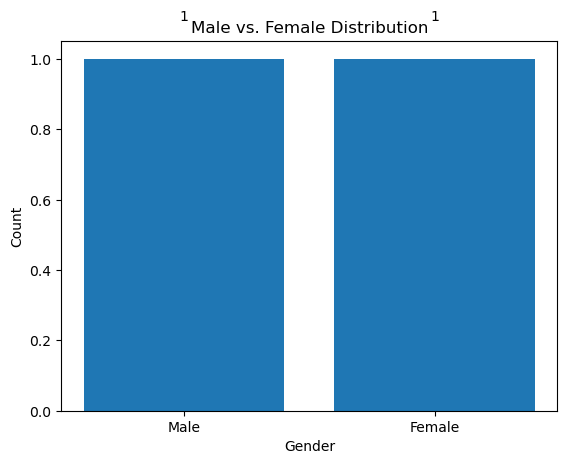

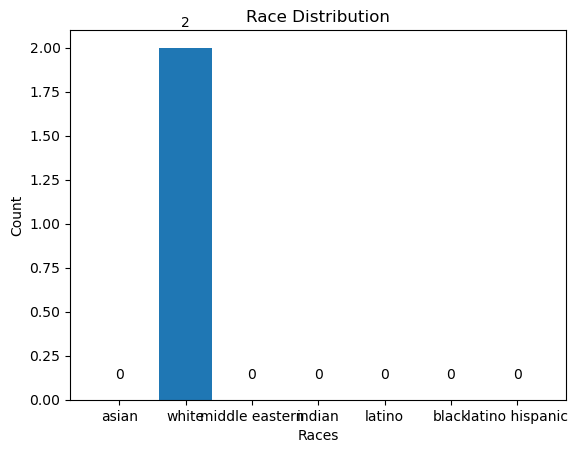

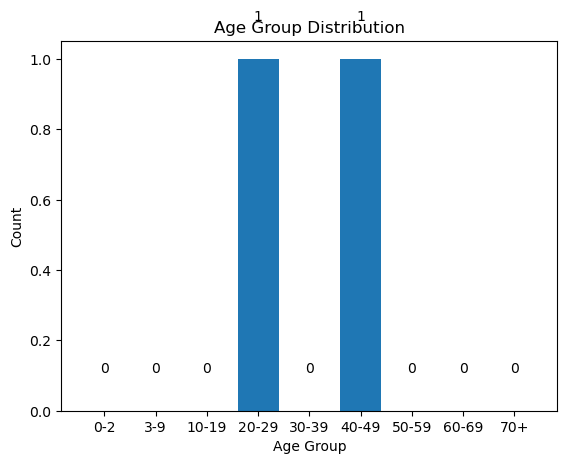

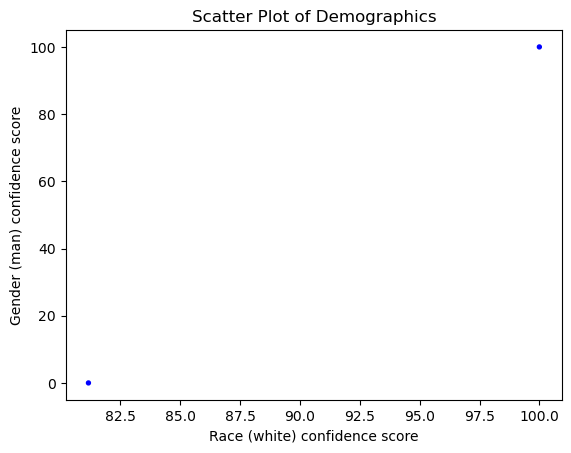

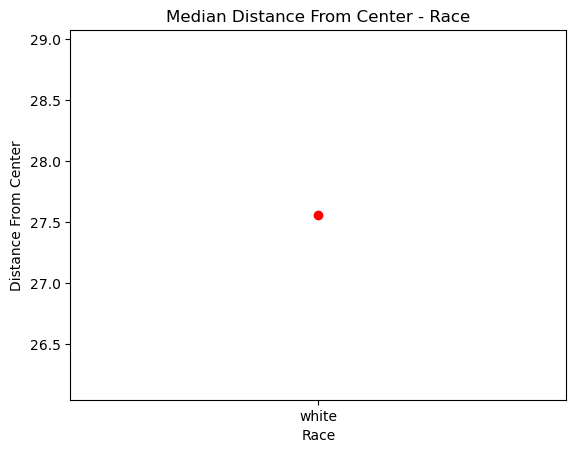

In [158]:
MetricGenderDisplay(FairFaceDict, specific_race=None, specific_age=None)
MetricRaceDisplay(FairFaceDict, specific_gender=None, specific_age=None)
MetricAgeDisplay(FairFaceDict, specific_gender=None, specific_race=None)
ScatterPlotDisplay2D(FairFaceDict, x_axis_label="race", y_axis_label="gender", specific_gender="man", specific_race="white")
ScatterPlotDisplay3D(FairFaceDict, specific_gender="man", specific_race="white", specific_age="10-19")
MetricCenterDistanceDisplay(FairFaceDict, distance_val_list=dist_bet_centers, area_val_list=space_taken_up, category='race', type='distance') 

In [22]:
def ShannonSimpsonMetrics(data):
    prob_gender = {"man": 0, "woman": 0}
    prob_race = {"asian": 0, "white": 0, "middle eastern": 0, "indian": 0, "latino hispanic": 0, "black": 0}
    prob_age = {"0-2":0,"3-9":0,"10-19":0,"20-29":0,"30-39":0,"40-49":0,"50-59":0,"60-69":0,"70+":0}
    dict_list = [prob_gender, prob_race, prob_age]

    # Working out the number of each metric present across the set of images
    for index in range(len(data)):
        prob_gender[data[index][1]["gender"]] += 1

        prob_race[data[index][1]["race"]] += 1

        prob_age[data[index][1]["age"]] += 1

    # Working out the probability that each metric is present across the set of images
    for dict in dict_list:
        for item in dict:
            dict[item] /= len(data)

    # Working out the shannon entropy for each metric
    shannonEntropy = {"gender":0, "race":0, "age":0}
    for index, dict in enumerate(dict_list):
        shannon_val = 0
        for item in dict:
            # Ignoring 0 values as ln(0) is undefined 
            if dict[item] != 0:
                shannon_val += dict[item]*math.log(dict[item])
        shannon_val = -shannon_val
        shannonEntropy[list(shannonEntropy.keys())[index]] = shannon_val

    simpsonIndex = {"gender":0, "race":0, "age":0}
    for index, dict in enumerate(dict_list):
        simpson_val = 0
        for item in dict:
            simpson_val += dict[item]**2
        simpson_val = 1/simpson_val
        simpsonIndex[list(simpsonIndex.keys())[index]] = simpson_val

    shannonEvenness = shannonEntropy.copy()
    gender_count = sum(1 for value in prob_gender.values() if value > 0)
    race_count = sum(1 for value in prob_race.values() if value > 0)
    age_count = sum(1 for value in prob_age.values() if value > 0)

    if shannonEvenness["gender"] != 0:
        shannonEvenness["gender"] /= math.log(gender_count)

    if shannonEvenness["race"] != 0:
        shannonEvenness["race"] /= math.log(race_count)

    if shannonEvenness["age"] != 0:
        shannonEvenness["age"] /= math.log(age_count)

    simposonEvenness = simpsonIndex.copy()
    simposonEvenness["gender"] /= gender_count
    simposonEvenness["race"] /= race_count
    simposonEvenness["age"] /= age_count

    return {"ShannonEntropy":shannonEntropy, "SimpsonIndex":simpsonIndex, "ShannonEvenness":shannonEvenness, "SimpsonEvenness":simposonEvenness}


In [21]:
ShannonSimpsonMetrics(FairFaceDict)

{'ShannonEntropy': {'gender': 0.33678521072283274,
  'race': 0.9434197471064367,
  'age': 1.1296779481531973},
 'SimpsonIndex': {'gender': 1.2324062385470538,
  'race': 1.785098326039,
  'age': 2.576158940397351},
 'ShannonEvenness': {'gender': 0.48587835335457535,
  'race': 0.5265325861583926,
  'age': 0.7019083739892035},
 'SimpsonEvenness': {'gender': 0.6162031192735269,
  'race': 0.2975163876731667,
  'age': 0.5152317880794702}}

In [23]:
def CorrelationMetric(data):
    correlation_gender = {"man": 0, "woman": 0}
    correlation_race = {"asian": 0, "white": 0, "middle eastern": 0, "indian": 0, "latino hispanic": 0, "black": 0}
    correlation_age = {"0-2":0,"3-9":0,"10-19":0,"20-29":0,"30-39":0,"40-49":0,"50-59":0,"60-69":0,"70+":0}
    count = len(data)
    dict_list = [correlation_gender, correlation_race, correlation_age]

    # Working out the number of each metric present across the set of images
    for index in range(len(data)):
        correlation_gender[data[index][1]["gender"]] += 1

        correlation_race[data[index][1]["race"]] += 1

        correlation_age[data[index][1]["age"]] += 1

    for dict in dict_list:
        for item in dict:
            # Divide all values in the dictionary by count
            dict[item] /= count
            if dict[item] > 1/len(dict):
                print(item, "is positively correlated with the image type. ",dict[item], " > ", 1/len(dict))

In [161]:
CorrelationMetric(FairFaceDict)

white is positively correlated with the image type.  1.0  >  0.16666666666666666
20-29 is positively correlated with the image type.  0.5  >  0.1111111111111111
40-49 is positively correlated with the image type.  0.5  >  0.1111111111111111


### DeepFace Model

In [12]:
# Function copied from FYP - Pipeline.ipynb
def DeepFaceProcess(listOfImages):
    """ 
    Description:
    This function serves to determine the properties of the primary detected face in an image. 
    For each image passed it will only consider the most prominent face, this is done as each 
    image is initially being processed by YOLOv8 to detect/crop individual people and then said images are fed to this function.
    
    Parameters:
    listOfImages (list) - List containing the images to be processed. 

    Returns:
    DeepFaceDict (dict) - Dictionary containing the information relevant to each image.
    """
        
    tensorflow.keras.utils.disable_interactive_logging()
    DeepFaceDict = {}
    counter = 0
    
    # Create a tqdm progress bar
    progress_bar = tqdm(total=len(listOfImages), desc="Processing", unit="images")
    
    for image in listOfImages:
        try:
            # Retrieving the age/gender/race/emotion of the image
            # Note: enforce_detection=False used so that images where the face isn't fully visible are still considered
            # Note: silent=True used to remove in built progress bar
            image =  image[:,:,:3]

            objs = DeepFace.analyze(image, actions = ['age', 'gender', 'race', 'emotion'], enforce_detection=False,  detector_backend="mtcnn", silent=True)
            
            # Using the index of the primary face (takes up most area) in the image
            index =  FindObjWithLargestArea(objs)
            
            # Replacing the dictionary keys to keep in line with the rest of the naming conventions (Man -> male/Woman-> female)
            objs[index]["gender"]["male"] = objs[index]["gender"]["Man"]
            del objs[index]["gender"]["Man"]

            objs[index]["gender"]["female"] = objs[index]["gender"]["Woman"]
            del objs[index]["gender"]["Woman"]

            # Replacing the labels to keep in line with the rest of the naming conventions
            if objs[index]['dominant_gender'] == "Man":
                objs[index]['dominant_gender'] = "male"
            elif objs[index]['dominant_gender'] == "Woman":
                objs[index]['dominant_gender'] = "female"
            
            ImageInfo = {'age':objs[index]['age'], 'gender':objs[index]['dominant_gender'], 'race':objs[index]['dominant_race'], 'emotion':objs[index]['dominant_emotion']}

            # Cropping the image to only include the face
            objs[index]['region']
            x = objs[index]['region']['x']
            y = objs[index]['region']['y']
            width = objs[index]['region']['x'] + objs[index]['region']['w']
            height = objs[index]['region']['y'] + objs[index]['region']['h']
            croppedImg = image[y:height, x:width]
            
            # Storing the images in a dictionary, ImageInfo contains the general info, objs contains the full detailed info (percentages of each class)
            DeepFaceDict[counter] = [croppedImg, ImageInfo, objs[index]]
            counter+=1
        except Exception as error:
            counter-=1
            plt.imshow(image[:,:,:3])
            plt.show()
            print("Error: ",error)
            
        # Update the progress bar
        progress_bar.update(1)
    return DeepFaceDict

### Ensamble Model

In [11]:
# This function expectes the images to contain the face only and not the entire image
def ensmableProcess(listOfImages, fairFaceModel):
    tensorflow.keras.utils.disable_interactive_logging()
    EnsambleDict = {}
    no_of_models = 2
    
    # Create a tqdm progress bar
    progress_bar = tqdm(total=len(listOfImages), desc="Processing", unit="images")

    # Transformation process used to convert images to the expected input format of the fairface model.
    trans = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    for image_index, image in enumerate(listOfImages):

        final_gender_mapping = {}
        final_race_mapping = {}
        # final_age_mapping = {}

        # ResNet mappings
        gender_mapping = {"man":0,"woman":1}
        race_mapping = {"white":0,"black":1,"latino hispanic":2,"asian":3,"indian":4,"middle eastern":5}
        age_mapping = {"0-2":0,"3-9":1,"10-19":2,"20-29":3,"30-39":4,"40-49":5,"50-59":6,"60-69":7,"70+":8}

        # processing the image and getting the cropped version generated via mtcnn
        objs = DeepFace.analyze(image, actions = ['age', 'gender', 'race'], enforce_detection=False,  detector_backend="mtcnn", silent=True)

        # Using the index of the primary face (takes up most area) in the image
        index =  FindObjWithLargestArea(objs)

        # Cropping the image to only include the face
        img_area = objs[index]['region']
        x = img_area['x']
        y = img_area['y']
        width = img_area['x'] + img_area['w']
        height = img_area['y'] + img_area['h']
        faceImg = image[y:height, x:width]

        # Converting the cropped image to tensor and reshaping it to match the ResNet model input
        transformed_image = trans(faceImg)
        transformed_image = transformed_image.view(1, 3, 224, 224) 
        transformed_image = transformed_image.to("cpu")

        outputs = fairFaceModel(transformed_image)
        outputs = outputs.cpu().detach().numpy()
        outputs = np.squeeze(outputs)

        gender_outputs = outputs[7:9]
        age_outputs = outputs[9:18]

        # This array has probabilities for east asian and southeast asian, so we need to combine them
        race_outputs = outputs[:7]
        # Their values are stored in index 3 and 4, so we will take the average of these two values and store at index 3
        race_outputs[3] = np.mean(race_outputs[3:5])
        # Now we remove the extra value at index 4
        race_outputs = np.delete(race_outputs, 4)

        gender_score = np.exp(gender_outputs) / np.sum(np.exp(gender_outputs))
        age_score = np.exp(age_outputs) / np.sum(np.exp(age_outputs))
        race_score = np.exp(race_outputs) / np.sum(np.exp(race_outputs))

        # Setting the appropriate scores for each category
        for gender in ["man", "woman"]:
            # * 100 to convert the score to a percentage to match DeepFace model output
            gender_mapping[gender] = gender_score[gender_mapping[gender]]*100

        for race in ["white", "black", "latino hispanic", "asian", "indian", "middle eastern"]:
            race_mapping[race] = race_score[race_mapping[race]]*100

        for age_range in ["0-2","3-9","10-19","20-29","30-39","40-49","50-59","60-69","70+"]:
            age_mapping[age_range] = age_score[age_mapping[age_range]]*100

        # Ensabling the results from the ResNet model and the DeepFace model
        final_gender_mapping["man"] = (objs[0]["gender"]["Man"] + gender_mapping["man"])/no_of_models
        final_gender_mapping["woman"] = (objs[0]["gender"]["Woman"] + gender_mapping["woman"])/no_of_models

        for race in ["white", "black", "latino hispanic", "asian", "indian", "middle eastern"]:
            final_race_mapping[race] = (objs[0]["race"][race] + race_mapping[race])/no_of_models

        # Determing the final results from the ensamble techniuqe
        final_gender = max(final_gender_mapping, key=final_gender_mapping.get)
        final_race = max(final_race_mapping, key=final_race_mapping.get)
        final_age = max(age_mapping, key=age_mapping.get)

        # Converting the age to a sufficient range (Assuming 100 is the max age)
        if final_age == "70+":
            final_age = "70-100"

        # Calculating the mean of the age range
        age_mean = np.mean([int(value) for value in final_age.split("-")])

        # Calculating the mean of the model ages
        ensamble_age = np.mean([age_mean, objs[0]["age"]])

        age_ranges = [(0, 2), (3, 9), (10, 19), (20, 29), (30, 39), (40, 49), (50, 59), (60, 69), (70, 100)]

        # Determining the final age range based on the mean of the model ages
        for range_start, range_end in age_ranges:
            if ensamble_age in range(range_start, range_end + 1):
                if range_start == 70:
                    final_age = "70+"
                else:
                    final_age = f"{range_start}-{range_end}"
                break
        
        ImageInfo = {"age":final_age, "gender":final_gender, "race":final_race}
        imageConfidenceData = {"race":final_race_mapping, "gender":final_gender_mapping, "age":age_mapping}
        EnsambleDict[image_index] = [faceImg, ImageInfo, imageConfidenceData]

        # Update the progress bar
        progress_bar.update(1)

    return EnsambleDict

In [118]:
# Loading the images to be processed
list_of_images = LoadImagesFromFolder("C:\\Users\\User\\FYP\\DownloadedImages\\LAION-400M\\nurseImageSubsetsForProcessing\\SubSet_2_OnePerson")

# Setting the human detection confidence threshold
confidence_threshold = 0.5
# Loading the YOLO model. This is downloaded automatically when run for the first time.
model = YOLO('yolov8n.pt')
# Retrieving the images of people detected in the images, the distance between the person and image center and the space taken up by the person
people_images, dist_bet_centers, space_taken_up = YOLODetectPerson(model, list_of_images, confidence_threshold)

# Loading the FairFace model, the res34_fair_align_multi_7_20190809.pt is used as it detects 7 distinct races as opposed to the other model.
model_fair_7 = torchvision.models.resnet34(pretrained=True)
model_fair_7.fc = nn.Linear(model_fair_7.fc.in_features, 18)
model_fair_7.load_state_dict(torch.load('C:\\Users\\User\\FYP\\Testing\\res34_fair_align_multi_7_20190809.pt', map_location=torch.device('cpu')))
model_fair_7 = model_fair_7.to("cpu")
model_fair_7.eval()

# Processing the images using the ensamble model
EnsambleDict = ensmableProcess(people_images, model_fair_7)

# Adding the distance between centers and space taken up by the person to the dictionary so that it contains all relevant information.
for index in EnsambleDict.keys():
    tmp = {"center_dist":dist_bet_centers[index], "space": space_taken_up[index]}
    EnsambleDict[index][1].update(tmp)

# Saving the metrics to disk
metric_save_directoy = "DeepFaceShit"#"Doctor(DeepFace)"
save_metrics = True
if save_metrics == True:
    # Checking if the folder exists, and if not, creating it
    sub_folder_path = Path("..\\DownloadedImages\\"+CamelCase(metric_save_directoy))
    if not sub_folder_path.exists():
        sub_folder_path.mkdir()

    # Checking if the folder exists, and if not, creating it
    sub_folder_path = Path("..\\DownloadedImages\\"+CamelCase(metric_save_directoy)+"\\DeepFaceImagesMetrics")
    if not sub_folder_path.exists():
        sub_folder_path.mkdir()

    # Saving the general info metrics to csv file
    SaveMetricsCSV(sub_folder_path, EnsambleDict)

    # Saving the cropped images used by the DeepFace API to disk
    for imgIndex in range(len(EnsambleDict.items())):
        save_path = os.path.join(sub_folder_path,str(imgIndex)+".jpg")
        cv2.imwrite(save_path, cv2.cvtColor(EnsambleDict[imgIndex][0], cv2.COLOR_BGR2RGB))

['0.jpg', '1.jpg', '2.jpg', '3.jpg', '4.jpg', '5.jpg', '6.jpg', '7.jpg', '8.jpg', '9.jpg', '10.jpg', '11.jpg', '12.jpg', '13.jpg', '14.jpg', '15.jpg', '16.jpg', '17.jpg', '18.jpg', '19.jpg', '20.jpg', '21.jpg', '22.jpg', '23.jpg', '24.jpg', '25.jpg', '26.jpg', '27.jpg', '28.jpg', '29.jpg', '30.jpg', '31.jpg', '32.jpg', '33.jpg', '34.jpg', '35.jpg', '36.jpg', '37.jpg', '38.jpg', '39.jpg', '40.jpg', '41.jpg', '42.jpg', '43.jpg', '44.jpg', '45.jpg', '46.jpg', '47.jpg', '48.jpg', '49.jpg', '50.jpg', '51.jpg', '52.jpg', '53.jpg', '54.jpg', '55.jpg', '56.jpg', '57.jpg', '58.jpg', '59.jpg', '60.jpg', '61.jpg', '62.jpg', '63.jpg', '64.jpg', '65.jpg', '66.jpg', '67.jpg', '68.jpg', '69.jpg', '70.jpg', '71.jpg', '72.jpg', '73.jpg', '74.jpg', '75.jpg', '76.jpg', '77.jpg', '78.jpg', '79.jpg', '80.jpg', '81.jpg', '82.jpg', '83.jpg', '84.jpg', '85.jpg', '86.jpg', '87.jpg', '88.jpg', '89.jpg', '90.jpg', '91.jpg', '92.jpg', '93.jpg', '94.jpg', '95.jpg', '96.jpg']



0: 480x640 1 person, 319.1ms
Speed: 10.0ms preprocess, 319.1ms inference, 3.0ms postprocess per image at shape (1, 3, 480, 640)

0: 640x640 1 person, 346.1ms
Speed: 7.0ms preprocess, 346.1ms inference, 5.0ms postprocess per image at shape (1, 3, 640, 640)

0: 480x640 1 person, 289.1ms
Speed: 13.0ms preprocess, 289.1ms inference, 3.0ms postprocess per image at shape (1, 3, 480, 640)

0: 640x448 1 person, 302.1ms
Speed: 12.0ms preprocess, 302.1ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 448)

0: 448x640 1 person, 305.1ms
Speed: 14.0ms preprocess, 305.1ms inference, 3.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 298.1ms
Speed: 12.0ms preprocess, 298.1ms inference, 3.0ms postprocess per image at shape (1, 3, 448, 640)

0: 640x480 1 person, 348.1ms
Speed: 15.0ms preprocess, 348.1ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 480)

0: 640x480 1 person, 302.1ms
Speed: 12.0ms preprocess, 302.1ms inference, 3.0ms postprocess per i

Processing: 100%|██████████| 97/97 [07:54<00:00,  4.89s/images]


In [112]:
MetricGenderDisplay(EnsambleDict, specific_race=None, specific_emotion=None, specific_age=None)
MetricRaceDisplay(EnsambleDict, specific_gender=None, specific_emotion=None, specific_age=None)
MetricAgeDisplay(EnsambleDict, specific_gender=None, specific_emotion=None, specific_race=None)
ScatterPlotDisplay2D(EnsambleDict, x_axis_label="race", y_axis_label="gender", specific_gender="man", specific_race="white", specific_emotion=None)
ScatterPlotDisplay3D(EnsambleDict, specific_gender="man", specific_race="white", specific_age="10-19")
MetricCenterDistanceDisplay(EnsambleDict, distance_val_list=dist_bet_centers, area_val_list=space_taken_up, category='race', type='distance') 

In [113]:
ShannonSimpsonMetrics(EnsambleDict)

In [114]:
CorrelationMetric(EnsambleDict)

## Comparing DeepFace / FairFace model

The dataset used for comparison is the UTK-Face dataset as none of the models were trained on it. link: https://susanqq.github.io/UTKFace/

In [12]:
# Loads the UTK-Face dataset part 1
UTK_dataset_path = "C:\\Users\\User\\FYP\\Datasets\\UTK-Face\\part1"
file_list = os.listdir(UTK_dataset_path)
UTK_loaded_images = []

for image_name in file_list:

    image_path = os.path.join(UTK_dataset_path, image_name)
    # loading the image
    image = dlib.load_rgb_image(image_path)

    image_info = image_name.split("_")

    # Converting from 0 -> man and 1 -> woman
    image_info[1] = "man" if image_info[1] == "0" else "woman"

    # Converting from 0 -> white, 1 -> black, 2 -> asian, 3-> indian and 4-> other (Hispanic, Latino, Middle Eastern)
    if image_info[2] == "0":
        image_info[2] = "white"
    elif image_info[2] == "1":
        image_info[2] = "black"
    elif image_info[2] == "2":
        image_info[2] = "asian"
    elif image_info[2] == "3":
        image_info[2] = "indian"
    else:
        image_info[2] = "other"

    image_data = {"image":image, "age":image_info[0], "gender":image_info[1], "race":image_info[2]}
    UTK_loaded_images.append(image_data)

In [13]:
# Randomly selecting images from the UTK dataset to process
num_elements_to_select = 371

# Randomly select elements without replacement
UTK_random_images = random.sample(UTK_loaded_images, num_elements_to_select)

In [14]:
UTK_image_subset = []
# Retrieving the images only
for image in UTK_random_images:
    UTK_image_subset.append(image["image"])

In [42]:
# YOLOv8 person detection not used as UTK-Face

# Loading the FairFace model, the res34_fair_align_multi_7_20190809.pt is used as it detects 7 distinct races as opposed to the other model.
model_fair_7 = torchvision.models.resnet34(pretrained=True)
model_fair_7.fc = nn.Linear(model_fair_7.fc.in_features, 18)
model_fair_7.load_state_dict(torch.load('C:\\Users\\User\\FYP\\Testing\\res34_fair_align_multi_7_20190809.pt', map_location=torch.device('cpu')))
model_fair_7 = model_fair_7.to("cpu")
model_fair_7.eval()
# Processing the images using the FairFace model
EnsambleDict = ensmableProcess(UTK_image_subset, model_fair_7)

# Processing the images using the FairFace model
FairFaceDict = FairFaceProcess(UTK_image_subset, model_fair_7)

# Processing the images using the FairFace model
DeepFaceDict = DeepFaceProcess(UTK_image_subset)

Processing: 100%|██████████| 371/371 [35:05<00:00,  5.68s/images]


In [43]:
final_result_list = []
# Forming the final result list
for index, image_data in enumerate(UTK_random_images):
    final_result_list.append({"image_info":image_data, "deepface":DeepFaceDict[index][1], "fairface":FairFaceDict[index][1], "ensamble":EnsambleDict[index][1]})

In [57]:
# changing gender labels used for the sake of comparison wiht the UTK-Face dataset
for data in DeepFaceDict:
    if DeepFaceDict[data][1]["gender"] == "male":
       DeepFaceDict[data][1]["gender"] = "man"
    else:
        DeepFaceDict[data][1]["gender"] = "woman"

In [59]:
# Counting the number of correct predictions for each model

deepFaceGenderCorrectCount = 0
deepFaceRaceCorrectCount = 0
deepFaceAgeCorrectCount = 0

fairFaceGenderCorrectCount = 0
fairFaceRaceCorrectCount = 0
fairFaceAgeCorrectCount = 0

ensambleGenderCorrectCount = 0
ensambleRaceCorrectCount = 0
ensambleAgeCorrectCount = 0

for result in final_result_list:
    true_gender = result["image_info"]["gender"]
    true_age = result["image_info"]["age"]
    true_race = result["image_info"]["race"]

    deepface_gender = result["deepface"]["gender"]
    deepface_age = result["deepface"]["age"]
    deepface_race = result["deepface"]["race"]

    fairface_gender = result["fairface"]["gender"]
    fairface_age = result["fairface"]["age"]
    fairface_race = result["fairface"]["race"]

    ensamble_gender = result["ensamble"]["gender"]
    ensamble_age = result["ensamble"]["age"]
    ensamble_race = result["ensamble"]["race"]

    if true_gender.lower() == deepface_gender.lower():
        deepFaceGenderCorrectCount += 1

    if true_race.lower() == deepface_race.lower():
        deepFaceRaceCorrectCount += 1
    elif true_race.lower() == "other" and deepface_race in ["latino", "middle eastern"]:
        deepFaceRaceCorrectCount += 1

    # +6 so that the max range is included i.e., deepface_age = 15 range = 10-20 as otherwise it would be 10-19 
    if int(true_age) in range(deepface_age-5, deepface_age+6):
        deepFaceAgeCorrectCount += 1

    if true_gender.lower() == fairface_gender.lower():
        fairFaceGenderCorrectCount += 1

    #-----------------------------------------------------
    
    if true_race.lower() == fairface_race.lower():
        fairFaceRaceCorrectCount += 1
    elif true_race.lower() == "other" and fairface_race in ["latino", "middle eastern"]:
        deepFaceRaceCorrectCount += 1

    if fairface_age == "70+" and int(true_age) > 70:
        fairFaceAgeCorrectCount += 1
    elif fairface_age != "70+" and int(true_age) in range(int(fairface_age.split("-")[0]), int(fairface_age.split("-")[1])):
        fairFaceAgeCorrectCount += 1
    
    #-----------------------------------------------------
    
    if true_gender.lower() == ensamble_gender.lower():
        ensambleGenderCorrectCount += 1

    if true_race.lower() == ensamble_race.lower():
        ensambleRaceCorrectCount += 1
    elif true_race.lower() == "other" and ensamble_race in ["latino", "middle eastern"]:
        ensambleRaceCorrectCount += 1

    if fairface_age == "70+" and int(true_age) > 70:
        ensambleAgeCorrectCount += 1
    elif fairface_age != "70+" and int(true_age) in range(int(fairface_age.split("-")[0]), int(fairface_age.split("-")[1])):
        ensambleAgeCorrectCount += 1

### Comaprison Info Graphs

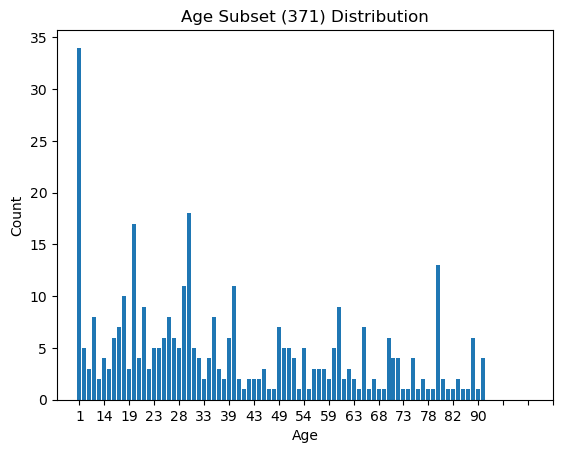

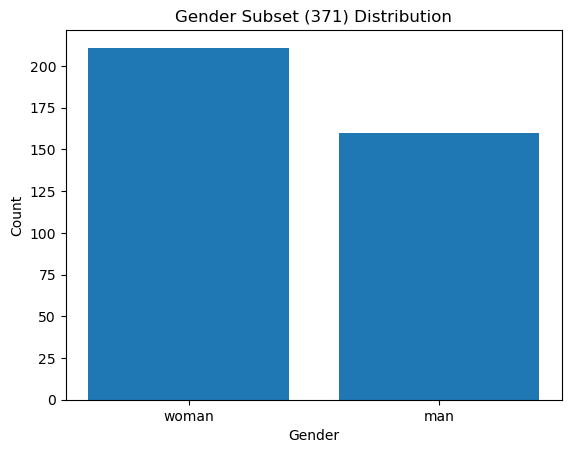

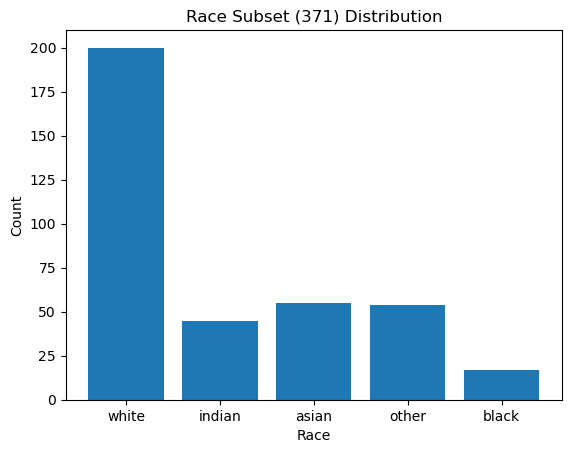

In [60]:
from collections import Counter
import matplotlib.pyplot as plt

# This function outputs the info regarding the images present in the dataset/subset
# Counting the number of each label present in the dataset subset
def datasetInfo(data, num_of_images):
    ages = [item["age"] for item in data]
    genders = [item["gender"] for item in data]
    races = [item["race"] for item in data]
    age_counts = Counter(ages)
    gender_counts = Counter(genders)
    race_counts = Counter(races)

    # Sort age counts by age
    sorted_age_counts = dict(sorted(age_counts.items()))

    # Plotting the bar graph
    plt.bar(sorted_age_counts.keys(), sorted_age_counts.values())
    plt.xlabel('Age')
    plt.ylabel('Count')
    plt.title('Age Subset ('+str(num_of_images)+') Distribution')
    plt.xticks(np.arange(0, int(max(ages)), 5))
    plt.show()

    # Plotting the bar graph
    plt.bar(gender_counts.keys(), gender_counts.values())
    plt.xlabel('Gender')
    plt.ylabel('Count')
    plt.title('Gender Subset ('+str(num_of_images)+') Distribution')
    plt.show()

    # Plotting the bar graph
    plt.bar(race_counts.keys(), race_counts.values())
    plt.xlabel('Race')
    plt.ylabel('Count')
    plt.title('Race Subset ('+str(num_of_images)+') Distribution')
    plt.show()

datasetInfo(UTK_random_images, num_elements_to_select)

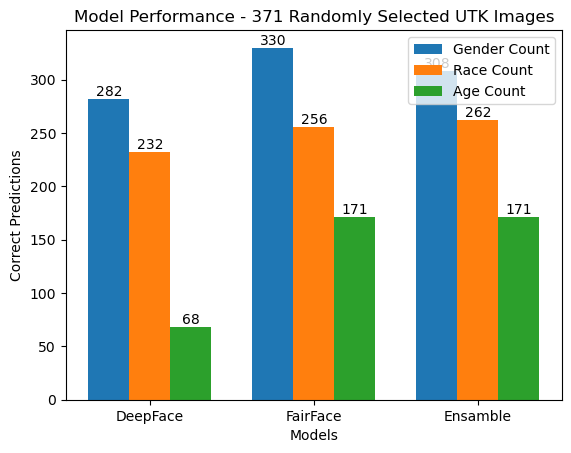

In [61]:
import matplotlib.pyplot as plt
import numpy as np

# This outputs the info on how each of the models performed on the dataset/subset

classes = ['DeepFace', 'FairFace', 'Ensamble']

gender_values = [deepFaceGenderCorrectCount, fairFaceGenderCorrectCount, ensambleGenderCorrectCount]
race_values = [deepFaceRaceCorrectCount, fairFaceRaceCorrectCount, ensambleRaceCorrectCount]
age_values = [deepFaceAgeCorrectCount, fairFaceAgeCorrectCount, ensambleAgeCorrectCount]

# Bar width
bar_width = 0.25

# Set positions for bars on X-axis
r1 = np.arange(len(classes))
r2 = [x + bar_width for x in r1]
r3 = [x + bar_width for x in r2]

# Create bar chart
plt.bar(r1, gender_values, width=bar_width, label='Gender Count')
plt.bar(r2, race_values, width=bar_width, label='Race Count')
plt.bar(r3, age_values, width=bar_width, label='Age Count')

# Display the numbers on top of each bar
for i, value in enumerate(gender_values):
    plt.text(r1[i], value + 0.1, str(value), ha='center', va='bottom')

for i, value in enumerate(race_values):
    plt.text(r2[i], value + 0.1, str(value), ha='center', va='bottom')

for i, value in enumerate(age_values):
    plt.text(r3[i], value + 0.1, str(value), ha='center', va='bottom')

# Set labels and title
plt.xlabel('Models')
plt.ylabel('Correct Predictions')
plt.title('Model Performance - '+str(num_elements_to_select)+' Randomly Selected UTK Images')

# Set x-axis ticks and labels
plt.xticks([r + bar_width for r in range(len(classes))], classes)

# Add legend
plt.legend()

# Show the plot
plt.show()

# Old Unused Functions

In [151]:
# def SaveMetricsCSVOld(sub_folder_path, metric_dict):
#     """ 
#     Description:
#     This function serves to save the dominant values per image resultant from the DeepFaceProcess function to a CSV file. (Used only in DeepFaceProcess function)
    
#     Parameters:
#     sub_folder_path (str) - Path to the folder in which the images are stored.
#     metric_dict (dict) - Dictionary containing the dominant values per image resultant from the DeepFaceProcess fucntion.

#     Returns:
#     None.
#     """
#     # Specifying the CSV file path
#     csv_file_path = Path(os.path.join(sub_folder_path, 'output_data.csv'))

#     # Opening the CSV file for writing
#     with open(csv_file_path, mode='w', newline='') as file:
#         fieldNames = ["Image_No"]
        
#         # Getting the additional fields from the dictionary and adding them to the fieldnames list
#         additionalFields = list(metric_dict[0][1].keys())
#         fieldNames.extend(additionalFields)
#         writer = csv.DictWriter(file, fieldnames=fieldNames)

#         # Writing the header row
#         writer.writeheader()

#         # Writing the image properties to the CSV file
#         for image_name, properties in metric_dict.items():
#             tmp = {'Image_No': image_name}
#             tmp.update({key: properties[1][key] for key in additionalFields})
#             writer.writerow(tmp)

In [ ]:
# def LoadMetricCSVFromFolderOld(csv_file_path):
#     """ 
#     Description:
#     This function is used to load the image metrics (if saved) from the DeepFaceProcess function, so as to avoid running it multiple times for the same images.

#     Parameters:
#     csv_file_path (str) - Path to the file containing the metrics.

#     Returns:
#     image_list (list) - List containing the loaded images.
#     """

#     data_dict = {}

#     with open(csv_file_path+"\\output_data.csv", mode='r', newline='') as file:
#         reader = csv.DictReader(file)
#         header = reader.fieldnames

#         for row in reader:
#             image_no = int(row['Image_No'])
            
#             image = cv2.cvtColor(cv2.imread(csv_file_path+"\\"+str(image_no)+".jpg"), cv2.COLOR_BGR2RGB)
#             tmp = {key: row[key] for key in header}
            
#             # Removing the 'Image_No' key as we dont want it saved in the dictionary
#             tmp.pop('Image_No', None)

#             data_dict[image_no] = [image,tmp]

#     return data_dict